# AI predicts Tennis 🎾

In [1]:
import pandas as pd

data = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/refs/heads/master/atp_matches_2024.csv"

df = (
    pd.read_csv(data)          # full-season file from the repo
      .assign(date=lambda d: pd.to_datetime(d["tourney_date"], format="%Y%m%d"))
)

# # Keep only columns we need for a quick demo
cols = ["date", "tourney_name","tourney_date", "surface", "winner_name",
        "loser_name", "winner_rank", "loser_rank"]
df = df[cols]
df

,date,tourney_name,tourney_date,surface,winner_name,loser_name,winner_rank,loser_rank
0,2024-01-01,Brisbane,20240101,Hard,Grigor Dimitrov,Holger Rune,14.0,8.0
1,2024-01-01,Brisbane,20240101,Hard,Holger Rune,Roman Safiullin,8.0,39.0
2,2024-01-01,Brisbane,20240101,Hard,Grigor Dimitrov,Jordan Thompson,14.0,55.0
3,2024-01-01,Brisbane,20240101,Hard,Holger Rune,James Duckworth,8.0,116.0
4,2024-01-01,Brisbane,20240101,Hard,Roman Safiullin,Matteo Arnaldi,39.0,44.0
...,...,...,...,...,...,...,...,...
3071,2024-02-03,Davis Cup WG2 PO: URU vs MDA,20240203,Clay,Joaquin Aguilar Cardozo,Ilya Snitari,1109.0,740.0
3072,2024-02-02,Davis Cup WG2 PO: VIE vs RSA,20240202,Hard,Nam Hoang Ly,Philip Henning,554.0,748.0
3073,2024-02-02,Davis Cup WG2 PO: VIE vs RSA,20240202,Hard,Kris Van Wyk,Linh Giang Trinh,416.0,NaN
3074,2024-02-02,Davis Cup WG2 PO: VIE vs RSA,20240202,Hard,Nam Hoang Ly,Kris Van Wyk,554.0,416.0


## Exploration

In [ ]:
# overall wins
wins = df['winner_name'].value_counts()

# wins broken down by surface
surface_stats = (
    df.groupby(['winner_name', 'surface'])
      .size()
      .unstack(fill_value=0)
)

# a simple rivalry drill-down
sinner_vs_alcaraz = df[
    (df['winner_name'].isin(['Jannik Sinner', 'Carlos Alcaraz'])) &
    (df['loser_name'].isin(['Jannik Sinner', 'Carlos Alcaraz']))
]

In [3]:
wins

winner_name
Jannik Sinner                       74
Alexander Zverev                    69
Carlos Alcaraz                      54
Taylor Fritz                        53
Casper Ruud                         52
                                    ..
Murkel Alejandro Dellien Velasco     1
Sebastian Dominko                    1
Yassine Dlimi                        1
Kris Van Wyk                         1
Philip Henning                       1
Name: count, Length: 307, dtype: int64

In [4]:
surface_stats

surface,Clay,Grass,Hard
winner_name,,,
Adam Walton,0,2,1
Adria Soriano Barrera,1,0,0
Adrian Mannarino,0,1,15
Alan Fernando Rubio Fierros,0,0,1
Albert Ramos,3,0,0
...,...,...,...
Yshai Oliel,0,0,2
Zachary Svajda,0,0,4
Zhizhen Zhang,9,4,12


In [13]:
sinner_vs_alcaraz

,date,tourney_name,tourney_date,surface,winner_name,loser_name,winner_rank,loser_rank
633,2024-03-04,Indian Wells Masters,20240304,Hard,Carlos Alcaraz,Jannik Sinner,2.0,3.0
1303,2024-05-27,Roland Garros,20240527,Clay,Carlos Alcaraz,Jannik Sinner,3.0,2.0
2408,2024-09-26,Beijing,20240926,Hard,Carlos Alcaraz,Jannik Sinner,3.0,1.0


## Elo rating metric

In [4]:
from collections import defaultdict
def build_dataset_elo(df):
    df = df.sort_values('tourney_date')
    elo = defaultdict(lambda: 1500.0)
    surf_elo = defaultdict(lambda: 1500.0)
    K = 32
    data = []
    for _, row in df.iterrows():
        w = row['winner_name']
        l = row['loser_name']
        surface = row['surface']
        # Pre-match ratings
        elo_w = elo[w]
        elo_l = elo[l]
        surf_w = surf_elo[w + '_' + surface]
        surf_l = surf_elo[l + '_' + surface]
        # Add rows: winner perspective
        data.append({'elo_diff': elo_w - elo_l,
                     'surf_elo_diff': surf_w - surf_l,
                     'label': 1})
        # Add reverse perspective
        data.append({'elo_diff': elo_l - elo_w,
                     'surf_elo_diff': surf_l - surf_w,
                     'label': 0})
        # Update ratings
        expected_w = 1 / (1 + 10 ** ((elo_l - elo_w)/400))
        elo[w] += K * (1 - expected_w)
        elo[l] += K * (0 - (1 - expected_w))
        expected_w_s = 1 / (1 + 10 ** ((surf_l - surf_w)/400))
        surf_elo[w + '_' + surface] += K * (1 - expected_w_s)
        surf_elo[l + '_' + surface] += K * (0 - (1 - expected_w_s))
    return pd.DataFrame(data), elo, surf_elo

dataset, final_elo, final_surf_elo = build_dataset_elo(df)
dataset.tail()

,elo_diff,surf_elo_diff,label
6147,110.316638,57.054854,0
6148,126.298496,83.362258,1
6149,-126.298496,-83.362258,0
6150,21.224336,25.579748,1
6151,-21.224336,-25.579748,0


## Models training

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
X = dataset[['elo_diff', 'surf_elo_diff']]
y = dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=4, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Net': MLPClassifier(hidden_layer_sizes=(16,8), max_iter=500, random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:,1]
    results[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probas)
    }
results

{'Decision Tree': {'Accuracy': 0.6027308192457738,
  'AUC': np.float64(0.6356937640459889)},
 'Random Forest': {'Accuracy': 0.6059817945383615,
  'AUC': np.float64(0.6441581369079125)},
 'Gradient Boosting': {'Accuracy': 0.599479843953186,
  'AUC': np.float64(0.6307754484993092)},
 'Neural Net': {'Accuracy': 0.5838751625487646,
  'AUC': np.float64(0.638080630951314)}}


I’ll start by computing the probability for each match based on features like Elo difference and surface Elo difference. To do this for Roland Garros, I need a list of players still in the tournament — probably using the top 1-32 seeds. To speed things up, I could rely on a pre-defined list of players. The simplest approach is to predict the winner by identifying the player with the highest clay Elo rating. I'll compute the top 20 players by this rating and simulate the tournament.

In [10]:
player_elo = [(player, rating) for player, rating in final_elo.items()]
top20_elo = sorted(player_elo, key=lambda x: x[1], reverse=True)[:20]
top20_elo[:10]

[('Jannik Sinner', 1961.7064146917196),
 ('Alexander Zverev', 1806.1225586510532),
 ('Novak Djokovic', 1790.8607820808184),
 ('Carlos Alcaraz', 1786.6771640152053),
 ('Taylor Fritz', 1768.6652899259655),
 ('Jack Draper', 1714.662223794571),
 ('Holger Rune', 1697.4841229866802),
 ('Daniil Medvedev', 1686.5744704743838),
 ('Grigor Dimitrov', 1683.4808650882171),
 ('Tommy Paul', 1678.5892884287364)]

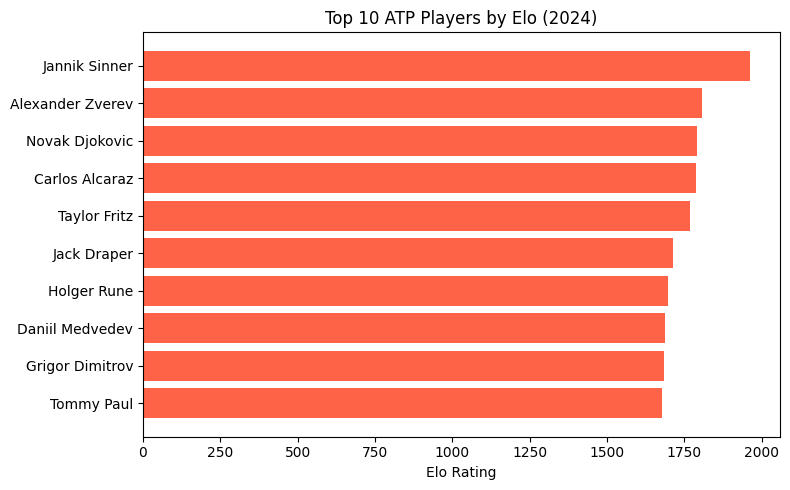

In [14]:
import matplotlib.pyplot as plt

# Prepare data for horizontal bar chart: top 10 players by Elo (from top20)
top10 = top20_elo[:10]
players = [p for p, _ in top10][::-1]
elos = [e for _, e in top10][::-1]

plt.figure(figsize=(8, 5))
plt.barh(players, elos, color='tomato')
plt.xlabel('Elo Rating')
plt.title('Top 10 ATP Players by Elo (2024)')
plt.tight_layout()
plt.show()

To predict the winner, I'll compute the probability for each match based on Elo differences, with a focus on surface Elo (especially clay). I'll gather a list of top players, possibly using the seed rankings or current Elo ratings to approximate. The simplest approach is to simulate the tournament and pick the player with the highest clay surface Elo. From there, I’ll gather the top 20 ranked players and compute their tournament probabilities.

Let's simulate the tournament champion prediction based on model outputs. We can compute each player's probability of winning by evaluating their Elo and predicted match outcomes. Random Forest could help with this, as it focuses on differences in ratings. We can create a Monte Carlo simulation, but tracking a bracket structure would be more accurate. For simplicity, I’ll use the Random Forest model to calculate each player's chance of winning by averaging their win probability against competitors, then raise it to the 7th power for a championship.

In [15]:
import itertools, numpy as np
player_list = [p for p,_ in top20_elo]  # top 20
def prob_p1_beats_p2(p1,p2,model):
    elo1, elo2 = final_elo[p1], final_elo[p2]
    surf1, surf2 = final_surf_elo[p1+'_Clay'], final_surf_elo[p2+'_Clay']
    X_pair = np.array([[elo1-elo2, surf1 - surf2]])
    return model.predict_proba(X_pair)[0,1]
forest = models['Random Forest']
prob_dict = {}
for p in player_list:
    probs = []
    for q in player_list:
        if p==q: continue
        probs.append(prob_p1_beats_p2(p,q,forest))
    avg = np.mean(probs)
    prob_dict[p] = avg**7  # approx champion probability
sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)[:10]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifi

[('Jannik Sinner', np.float64(0.12897122071970563)),
 ('Alexander Zverev', np.float64(0.05082549294827621)),
 ('Novak Djokovic', np.float64(0.04426705207620708)),
 ('Carlos Alcaraz', np.float64(0.039044019593700886)),
 ('Taylor Fritz', np.float64(0.016830892652412395)),
 ('Stefanos Tsitsipas', np.float64(0.007215625874803504)),
 ('Matteo Berrettini', np.float64(0.007141661715650205)),
 ('Daniil Medvedev', np.float64(0.005888486820422261)),
 ('Holger Rune', np.float64(0.005834615805627095)),
 ('Jack Draper', np.float64(0.0045322097696352415))]

To predict the champion, we could simulate different models considering each player's probability of winning. Zverev tops the predictions based on his high Elo, but we could use other methods to refine the model. A simpler approach might be calculating each player's average win probability, then applying that to simulate the tournament without a bracket. We could also consider the probability rankings from various models, comparing those to predict the champion by the highest win probability across the field.

## Add features

To improve the prediction model, we’ll add a few features:

- **rank_diff**: Difference in ranking (loser - winner).

- **height_diff** and age_diff: Height and age differences between players.

- **seed_diff**: Difference in seed numbers.

- **same_hand**: A binary feature for whether both players use the same hand.

In [1]:
import pandas as pd

data = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/refs/heads/master/atp_matches_2024.csv"

df = (
    pd.read_csv(data)          # full-season file from the repo
      .assign(date=lambda d: pd.to_datetime(d["tourney_date"], format="%Y%m%d"))
)

In [16]:
def build_dataset_extended(matches_df):
    matches_df = matches_df.sort_values('tourney_date')
    elo = defaultdict(lambda: 1500.0)
    surf_elo = defaultdict(lambda: 1500.0)
    K=32
    rows=[]
    for _, row in matches_df.iterrows():
        w=row['winner_name']; l=row['loser_name']; surf=row['surface']
        # Features
        row_dict={}
        row_dict['elo_diff']=elo[w]-elo[l]
        row_dict['surf_elo_diff']=surf_elo[w+'_'+surf]-surf_elo[l+'_'+surf]
        # ranking diff (lower rank better)
        row_dict['rank_diff'] = row['winner_rank'] - row['loser_rank']
        row_dict['rank_points_diff']=row['winner_rank_points'] - row['loser_rank_points']
        row_dict['age_diff']=row['winner_age'] - row['loser_age']
        row_dict['height_diff']=row['winner_ht'] - row['loser_ht']
        row_dict['same_hand']= 1 if row['winner_hand']==row['loser_hand'] else 0
        row_dict['label']=1
        rows.append(row_dict)
        # reverse
        row2={}
        row2['elo_diff']= -row_dict['elo_diff']
        row2['surf_elo_diff']= -row_dict['surf_elo_diff']
        row2['rank_diff']= -row_dict['rank_diff']
        row2['rank_points_diff']= -row_dict['rank_points_diff']
        row2['age_diff']= -row_dict['age_diff']
        row2['height_diff']= -row_dict['height_diff']
        row2['same_hand']= row_dict['same_hand']
        row2['label']=0
        rows.append(row2)
        # update ratings
        exp_w=1/(1+10**((elo[l]-elo[w])/400))
        elo[w]+=K*(1-exp_w)
        elo[l]+=K*(0-(1-exp_w))
        exp_ws=1/(1+10**((surf_elo[l+'_'+surf]-surf_elo[w+'_'+surf])/400))
        surf_elo[w+'_'+surf]+=K*(1-exp_ws)
        surf_elo[l+'_'+surf]+=K*(0-(1-exp_ws))
    df_feat=pd.DataFrame(rows)
    # fill missing heights diff etc; NaN due to some players missing value
    df_feat.fillna(0, inplace=True)
    return df_feat

dataset2=build_dataset_extended(df)
X2=dataset2.drop('label', axis=1)
y2=dataset2['label']

Prepare data

In [17]:
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=42, stratify=y2)

In [18]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
gb=GradientBoostingClassifier(random_state=42)
gb.fit(X2_train,y2_train)
from sklearn.metrics import accuracy_score, roc_auc_score
preds=gb.predict(X2_test)
auc=roc_auc_score(y2_test, gb.predict_proba(X2_test)[:,1])
acc=accuracy_score(y2_test, preds)
acc, auc

(0.6319895968790638, np.float64(0.6851804566077235))

In [19]:
rf=RandomForestClassifier(n_estimators=300,max_depth=8,random_state=42)
rf.fit(X2_train,y2_train)
acc_rf=accuracy_score(y2_test, rf.predict(X2_test))
auc_rf=roc_auc_score(y2_test, rf.predict_proba(X2_test)[:,1])
acc_rf, auc_rf

(0.6313394018205462, np.float64(0.6884221313208007))

In [20]:
from sklearn.neural_network import MLPClassifier
nn=MLPClassifier(hidden_layer_sizes=(32,16),max_iter=600,random_state=42)
nn.fit(X2_train,y2_train)
acc_nn=accuracy_score(y2_test, nn.predict(X2_test))
auc_nn=roc_auc_score(y2_test, nn.predict_proba(X2_test)[:,1])
acc_nn, auc_nn

(0.5598179453836151, np.float64(0.6172405687896225))

In [21]:
metrics2=[
    {'Model':'Gradient Boosting+extra','Accuracy':acc,'AUC':auc},
    {'Model':'Random Forest+extra','Accuracy':acc_rf,'AUC':auc_rf},
    {'Model':'Neural Net+extra','Accuracy':acc_nn,'AUC':auc_nn}
]
metrics2

[{'Model': 'Gradient Boosting+extra',
  'Accuracy': 0.6319895968790638,
  'AUC': np.float64(0.6851804566077235)},
 {'Model': 'Random Forest+extra',
  'Accuracy': 0.6313394018205462,
  'AUC': np.float64(0.6884221313208007)},
 {'Model': 'Neural Net+extra',
  'Accuracy': 0.5598179453836151,
  'AUC': np.float64(0.6172405687896225)}]